In [1]:
import numpy as np 
import pandas as pd 
import re
import string
import nltk
from nltk.corpus import stopwords
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection, feature_extraction, linear_model
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer

一、数据预处理

1.读取数据并分析其基本结构

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


分析以上数据，可得训练集共含有5个属性，其中target属性为样本的标签，即我们应当对测试集做出的预测值
text属性为训练主体，keyword和location属性均存在缺失

2.检查数据缺失比例

In [4]:
train_perc_missing = train.isnull().mean()*100
percentage_missing = pd.DataFrame({'Train Missing Percentage': train_perc_missing.sort_values(ascending=False)})
percentage_missing

,Train Missing Percentage
location,33.272035
keyword,0.801261
target,0.000000
text,0.000000
id,0.000000


In [5]:
test_perc_missing = test.isnull().mean()*100
percentage_missing = pd.DataFrame({'Test Missing Percentage': test_perc_missing.sort_values(ascending=False)})
percentage_missing

,Test Missing Percentage
location,33.864542
keyword,0.796813
text,0.000000
id,0.000000


对于训练集和测试集而言，keyword的缺失率均在33%左右，location的缺失率均在0.8%左右

3.分析数据分布

<AxesSubplot:ylabel='target'>

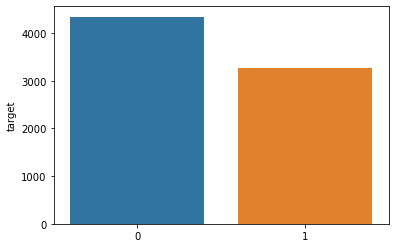

In [6]:
#灾难发生与未发生数量对比
sns.barplot(train['target'].value_counts().index, train['target'].value_counts())

<AxesSubplot:xlabel='keyword'>

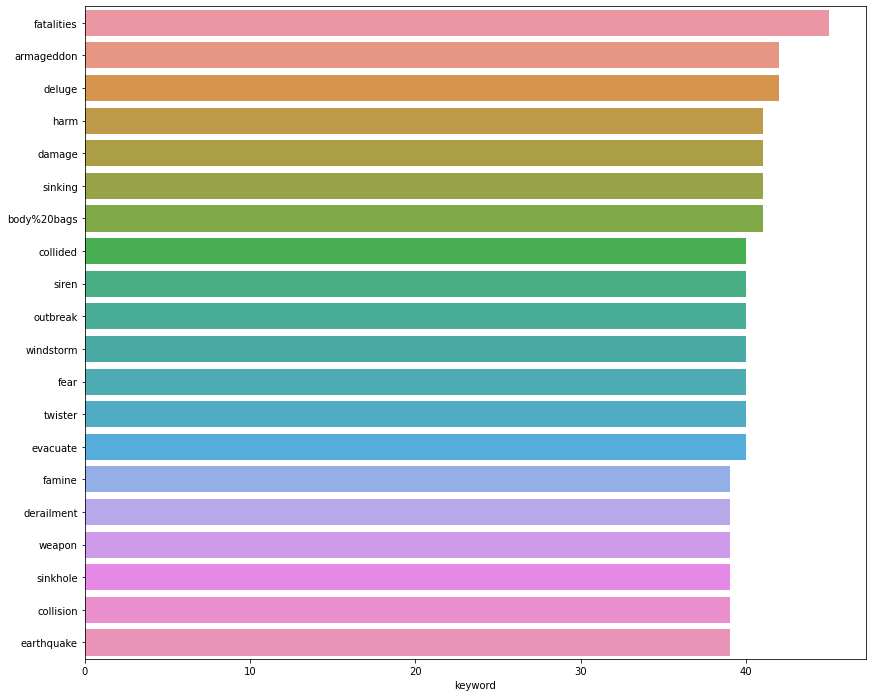

In [7]:
#关键词分布
figure = plt.figure(figsize=(14,12))
sns.barplot(y=train['keyword'].value_counts().index[:20], x=train['keyword'].value_counts()[:20])

<AxesSubplot:xlabel='location'>

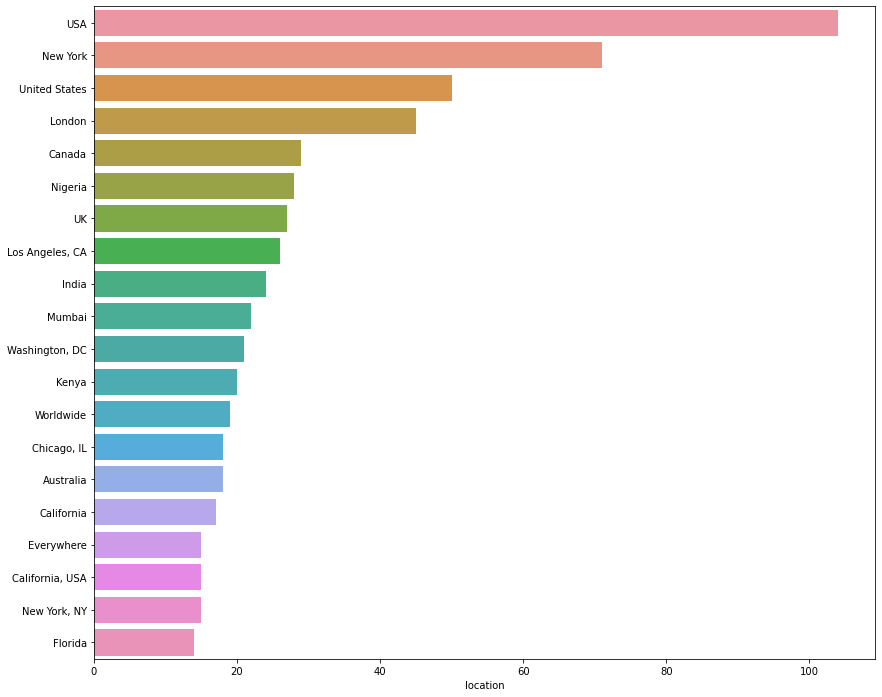

In [8]:
#地址分布
figure = plt.figure(figsize=(14,12))
sns.barplot(y=train['location'].value_counts().index[:20], x=train['location'].value_counts()[:20])

4.文本预处理

In [9]:
#转换为小写
def lowercase_text(text):
    text = text.lower()
    return text

train['text'] = train['text'].apply(lambda x: lowercase_text(x))
test['text'] = test['text'].apply(lambda x: lowercase_text(x))

In [10]:
#去除数字，符号等无用内容
def remove_noise(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
train['text'] = train['text'].apply(lambda x: remove_noise(x))
test['text'] = test['text'].apply(lambda x: remove_noise(x))

In [11]:
#去除停用词（即a，the等没有实际含义的冠词助词等）
from nlppreprocess import NLP

nlp = NLP()

train['text'] = train['text'].apply(nlp.process)
test['text'] = test['text'].apply(nlp.process) 

In [12]:
#变换单词形态，使其成为其词根
stemmer = SnowballStemmer("english")

def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]
    return ' '.join(text)

train['text'] = train['text'].apply(stemming)
test['text'] = test['text'].apply(stemming)

二、特征提取

In [13]:
# 将原文本转换为词向量以便于训练数据
count_vectorizer = CountVectorizer(analyzer='word', binary=True)
count_vectorizer.fit(train['text'])

train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])

y = train['target']

三、分类及评估

（考虑到不同分类方法的参数优化方法各不相同，因此这里直接用函数进行整合）

In [14]:
#决策树
def dtc(X,y):
    from sklearn.tree import  DecisionTreeClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import  GridSearchCV
    #训练模型
    dtc = DecisionTreeClassifier()
    dtc.fit(X,y)
    #使用交叉验证在训练集上进行分类器及其参数进行评估
    cross_val_score(dtc,X,y,cv=5, scoring="f1")
    #使用网格搜索方法寻找分类器最优参数组合
    dtc_best=DecisionTreeClassifier()
    params = {'min_samples_leaf':list(range(5,10,1)),'max_depth':list(range(3,10,1))}
    gsearch = GridSearchCV(dtc_best,params,n_jobs=-1,cv = 5,verbose=1)
    gsearch.fit(X,y)
    print(gsearch.best_params_,gsearch.best_score_)
    gsearch
    #使用优化参数后的模型生成提交结果文件
    predictions =gsearch.predict(test_vectors)
    sample_submission= pd.read_csv("sample_submission.csv")
    sample_submission['target'] =predictions
    sample_submission.to_csv("dtc_submission.csv", index=False)
# dtc(train_vectors, y)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s


{'max_depth': 9, 'min_samples_leaf': 9} 0.6326008647087196


[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    3.0s finished


In [18]:
#随机森林
def rfc(X,y):
    from sklearn.ensemble import  RandomForestClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import  GridSearchCV
    #训练模型
    rfc = RandomForestClassifier()
    rfc.fit(X,y)
    #使用交叉验证在训练集上进行分类器及其参数进行评估
    cross_val_score(rfc,X,y,cv=5, scoring="f1")
    #使用网格搜索方法寻找分类器最优参数组合
    rfc_best=RandomForestClassifier()
    params = {'n_estimators':list(range(50,300,50)),'max_depth':list(range(2,10,2))}
    gsearch = GridSearchCV(rfc_best,params,n_jobs=-1,cv = 5,verbose=1)
    gsearch.fit(X,y)
    print(gsearch.best_params_,gsearch.best_score_)
    gsearch
    #使用优化参数后的模型生成提交结果文件
    predictions =gsearch.predict(test_vectors)
    sample_submission= pd.read_csv("sample_submission.csv")
    sample_submission['target'] =predictions
    sample_submission.to_csv("rfc_submission.csv", index=False)
# rfc(train_vectors, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.8s finished


{'max_depth': 8, 'n_estimators': 150} 0.5910932068338045


In [26]:
#支持向量机
def svc(X,y):
    from sklearn.model_selection import cross_val_score
    from sklearn.svm import SVC
    from sklearn.model_selection import GridSearchCV
    svc = SVC()
    svc.fit(X, y)
    # 使用交叉验证在训练集上进行分类器及其参数进行评估
    cross_val_score(svc,X,y,cv=5, scoring="f1")
    # 使用网格搜索方法寻找分类器最优参数组合
    svc_best = SVC()
    params = {'C': [i/100 for i in range(150,170,1)],"kernel":['rbf','linear','sigmoid' ]}#继续修改参数已经无法得到更优结果
    gsearch = GridSearchCV(svc_best, params, n_jobs=-1, cv=5, verbose=1)
    gsearch.fit(X, y)
    print(gsearch.best_params_, gsearch.best_score_)
    gsearch
    # 使用优化参数后的模型生成提交结果文件
    predictions =gsearch.predict(test_vectors)
    sample_submission= pd.read_csv("sample_submission.csv")
    sample_submission['target'] =predictions
    sample_submission.to_csv("svc_submission.csv", index=False)
svc(train_vectors, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.8s finished


{'C': 1.59, 'kernel': 'rbf'} 0.7200905433376791


In [17]:
#多项分布朴素贝叶斯
def bnb(X,y):
    from sklearn.model_selection import cross_val_score
    from sklearn.naive_bayes import BernoulliNB
    bnb =BernoulliNB(alpha=1)
    bnb.fit(X, y)
    # 使用交叉验证在训练集上进行分类器及其参数进行评估
    print(cross_val_score(bnb,X,y,cv=5, scoring="f1"))
    predictions =bnb.predict(test_vectors)
    sample_submission= pd.read_csv("sample_submission.csv")
    sample_submission['target'] =predictions
    sample_submission.to_csv("bnb_submission.csv", index=False)
def cnb(X,y):
    from sklearn.model_selection import cross_val_score
    from sklearn.naive_bayes import ComplementNB
    cnb =ComplementNB(alpha=1)
    cnb.fit(X, y)
    # 使用交叉验证在训练集上进行分类器及其参数进行评估
    print(cross_val_score(cnb,X,y,cv=5, scoring="f1"))
    predictions =cnb.predict(test_vectors)
    sample_submission= pd.read_csv("sample_submission.csv")
    sample_submission['target'] =predictions
    sample_submission.to_csv("cnb_submission.csv", index=False)
bnb(train_vectors, y)
cnb(train_vectors, y)

[0.64588745 0.64102564 0.68138337 0.63689975 0.75528701]
[0.65179283 0.61872456 0.68413978 0.66966967 0.74180328]
